<a href="https://colab.research.google.com/github/EvgenEgorov/transcriptomics_msu_HW/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 4. Определение дифференциально экспрессированных генов. Работа с пакетами DESeq2 и edgeR.

В этом семинаре мы разберем работу с генерализованными линейными моделями для поиска дифференциально экспрессированных генов.

## Установка пакетов и импорт данных

Подгружаем заранее установленные пакеты

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown --id "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz

Устанавливаем еще несколько пакетов

In [ ]:
!pip install rpy2==3.5.1
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidyr")'
!Rscript -e 'install.packages("stringr")'
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("MASS")'

Импортируем пакеты

In [3]:
%%R

suppressPackageStartupMessages({
  library(edgeR)
  library(stringr)
  library(dplyr)
  library(tidyr)
  library(tximport)
  library(EnsDb.Mmusculus.v79)
  library(ggplot2)
  library(MASS)
})

Скачиваем данные, которыми мы будем пользоваться, в виде файлов, являющихся аутпутом (псевдо)картировщика salmon

In [ ]:
!wget -r -np -R "index.html*" http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/

In [5]:
!mkdir data
!mkdir data/samples
!mv arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/* data/samples

## Введение

### Постановка задачи

Для поиска дифференциально экспрессируемых генов мы будем пользоваться регрессией. Для начала давайте вспомним, в чем суть самого простого ее варианта - всем известной линейной регрессии.

Представим, что наша задача - изучить зависимость экспрессии гена X от возраста человека

In [ ]:
%%R

#сгенерируем симуляцию данных
set.seed(212)
age <- sample(1:70,50,replace=T)
expression <- sapply(age,function(i){
    mu = exp(0.03*i+log(20))
    rnbinom(1,mu=mu,size=5)
})
df <- data.frame(age=age,expr=expression)

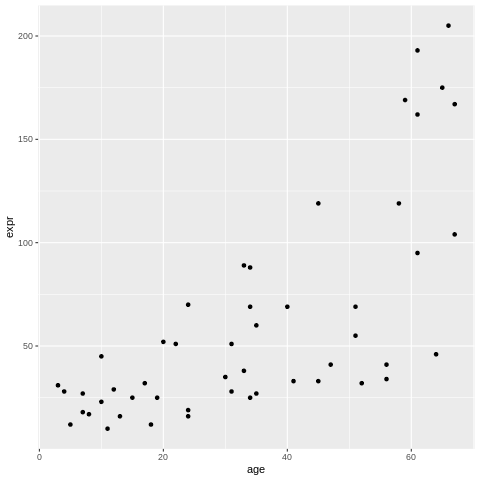

In [ ]:
%%R

ggplot(df,aes(x=age,y=expr))+
  geom_point()

Можем ли мы применить на этих данных линейную регрессию?

Нет, поскольку, как вы уже выяснили, каунты плохо описываются нормальным распределением. Куда лучше - отрицательным биномиальным.

### Генерализованные линейные модели

Чтобы, тем не менее, использовать для нашего анализа регрессию, воспользуемся генерализованными линейными моделями. Они позволяют расширить регрессию на случай, когда распределение зависимой переменной не нормальное, а какое-то друое из экспоненциального семейства.

*Для любителей математики:*

Распределение вероятностей принадлежит k-параметрическому экспоненциальному семейству, если его плотность может быть приведена к следующему виду:

\begin{align}
f(y)=exp\Big\{\sum_{i=1}^{k}\phi_iT_i(y)-\gamma(\phi_1,...,\phi_k)+S(y)\Big\},
\end{align}

где $\phi=(\phi_1,...,\phi_k)$ - k-мерный параметр$,\;T_i:Y→\mathbb{R},\;i=1,...,k,\;S:Y→\mathbb{R},\;γ:\mathbb{R}^k→\mathbb{R},\;Y$ не зависит от $\phi$.

Для нас важно, что этому семейству принадлежат следующие распределения (иногда для этого нужно зафиксировать некоторые из их параметров): биномиальное, отрицательное биномиальное, нормальное, логнормальное, Пуассона, Парето, Гамма-, Бета-, ...

Чтобы работать с отрицательным биномиальным распределением, нам понадобится следующий вид его функции вероятности:

\begin{align}
P[X=k]=\frac{\Gamma[k+\alpha^{-1}]}{\Gamma\alpha^{-1}\,\Gamma[k+1]}\Big(\frac{1}{1+\mu\alpha}\Big)^{\alpha^{-1}}\Big(\frac{\mu}{\alpha^{-1}+\mu}\Big)^{k}
\end{align}

Зададим распределение числа ридов на ген $g$ в образце $s$:

\begin{align}
Counts_{gs}∼NBinom(\mu_{gs},\alpha_g),
\end{align}

Матожидание $\mu_{sg}$ будет зависимой переменной в нашей регрессии:

\begin{align}
\mu_{gs}=s_s*q_{gs}
\end{align}

\begin{align}
\text{log}\,q_{gs}=\beta_{g0}+\beta_{g1}x_{s}
\end{align}

$x_{s}$ - независимая переменная (в нашем случае, возраст пациента $s$), $s_s$ - параметр для нормализации на общее число ридов в образце $s$.

Теперь мы видим, почему модель, несмотря на свой немного сложный вид, все еще линейная - в последней формуле с независимой переменной производятся только линейные преобразования (а при наличии нескольких независимых переменных мы бы рассматривали только их линейные комбинации).

Как и в случае обычной линейной регрессии, в первую очередь нас будет интересовать наклон прямой - коэффициент $\beta_{g1}$.

Чтобы найти оптимальное значение коэффициента, GLM используют оценку максимального правдоподобия модели (MLE).

Последовательность действий будет такая:
1.   Каким-то образом оценить $s_s$
2.   Каким-то образом оценить $\alpha_g$
3.   Найти оптимальные параметры $\beta_{g0}$ и $\beta_{g1}$

В том, как именно реализуются первые два пункта, и лежат основные различия между пакетами для анализа дифф. экспрессии.



Прежде, чем реализовать GLM самостоятельно, давайте посмотрим на табличку, призванную классифицировать разные модели регрессии.

<table>
  <tr>
    <th>Distribution \ Function g </th>
    <th>g(x_i^T)=x_i*β</th>
    <th>nonparametric g</th>
  </tr>
    <th>Gaussian</th>
    <td>Linear Regression</td>
    <td>Smoothing</td>
  <tr>
    <th>Exponential family</th>
    <td>Generalized Linear Models (GLM)</td>
    <td>Generalized Additive Models (GAM)</td>
  </tr>
</table>

Во второй половине курса мы столкнемся с другим классом моделей из этой таблички, а именно с генерализованными аддитивными моделями (GAM), когда будем говорить об изменениях экспрессии генов в проходящих дифференцировку клетках.

### Реализация GLM

Попробуем реализовать GLM на наших искусственных данных.

In [ ]:
%%R

model <- glm.nb(expr ~ age,data=df,link=log)
summary(model)


Call:
glm.nb(formula = expr ~ age, data = df, link = log, init.theta = 4.576132049)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8354  -1.0639  -0.2826   0.7238   1.4603  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 2.888467   0.141265   20.45   <2e-16 ***
age         0.029985   0.003478    8.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(4.5761) family taken to be 1)

    Null deviance: 129.471  on 49  degrees of freedom
Residual deviance:  51.047  on 48  degrees of freedom
AIC: 460.36

Number of Fisher Scoring iterations: 1


              Theta:  4.576 
          Std. Err.:  0.975 

 2 x log-likelihood:  -454.361 


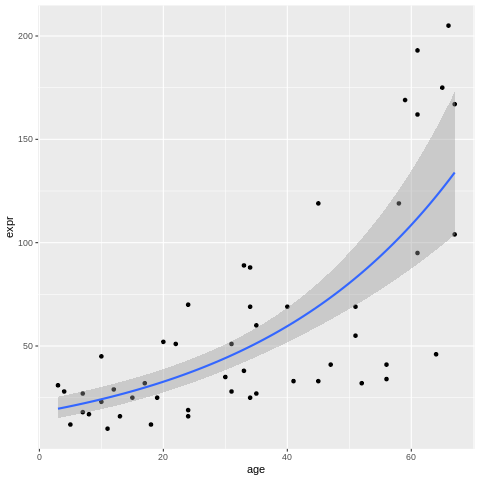

In [ ]:
%%R

ggplot(df,aes(x=age,y=expr))+
  geom_point()+
  geom_smooth(method=glm.nb,formula='y~x')

Реализовав регрессию таким образом, мы сделали два важных допущения: предположили, что $s_s$ и $\alpha_g$ равны 1. В реальной жизни это не так.

Прежде, чем мы посмотрим на реальный пример RNA-seq данных, давайте посмотрим на эту картинку и вспомним о том, что регрессию, в любом случае, нужно применять с умом )

<img src='https://imgs.xkcd.com/comics/linear_regression_2x.png' width=600>

## Реализация GLM для дифф. экспрессии

В реальной жизни независимые переменные очень редко числовые, и куда чаще - категориальные. Самая стандартная задача в транскриптомике - сравнение образцов здоровой ткани и больной, контрольных животных и подвергшихся какому-либо воздействию, дикого типа и нокаута, ...

Во всех этих случаях нам интересно, экспрессия каких генов различается между группами. Как же тогда быть?

Можно было бы воспользоваться каким-нибудь тестом для сравнения двух групп (t-тестом, тестом Манна-Уитни). Но, на самом деле, и регрессия нам подойдет!

В этом семинаре мы будем работать на датасете bulk RNA-seq почек мышей, полученном в лаборатории клеточной биологии рецепторов ИБХ РАН. В этом исследовании было два фактора, влияющих на экспрессию: нокаут по гену Insulin Receptor Related Receptor и различное воздействие на мышей: их поили либо обычной водой, либо водой с высоким содержанием бикарбоната.

Импортируем результаты Salmon с помощью tximport, пересчитывая каунты на уровне транскриптов. Отдельно сохраним табличку с целочисленными каунтами, отдельно - со значениями TPM.

\begin{align}
RPK\;(reads\;per\;kilobase)=\frac{read\;counts}{gene\;length\;(in\;Kb)}
\end{align}

\begin{align}
TPM\;(transcripts\;per\;kilobase\;million)=\frac{RPK}{\sum_{all\,genes\,in\,a\,sample}{RPK}}*1\,000\,000
\end{align}

Подготовим переменные для tximport:

In [ ]:
%%R

txdb <- EnsDb.Mmusculus.v79
tx2gene <- transcripts(txdb,return.type="DataFrame")
tx2gene <- tx2gene[c("tx_id","gene_id")]

samples <- str_c(c(str_c("wt_water_",c(1,2,3,4)),
                   str_c("wt_bicarb_",c(1,2,3,4)),
                   str_c("ko_water_",c(1,2,3,4)),
                   str_c("ko_bicarb_",c(1,2,3,4))),".sf")
files <- str_c("data/samples/",samples)

In [ ]:
%%R

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T)
tpm <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T, countsFromAbundance = "lengthScaledTPM")$counts

Посмотрим, какой объект выдает tximport

In [84]:
%%R

str(txi)

List of 4
 $ abundance          : num [1:39210, 1:16] 14.4325 0 0.4596 0.1018 0.0323 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:39210] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000031" ...
  .. ..$ : NULL
 $ counts             : num [1:39210, 1:16] 745 0 18 8 4 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:39210] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000031" ...
  .. ..$ : NULL
 $ length             : num [1:39210, 1:16] 1576 548 1192 2398 3775 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:39210] "ENSMUSG00000000001" "ENSMUSG00000000003" "ENSMUSG00000000028" "ENSMUSG00000000031" ...
  .. ..$ : NULL
 $ countsFromAbundance: chr "no"


Сохраним отдельно матрицу с каунтами и отдельно - с длинами транскриптов, после чего получим матрицу `normMat`, в которой скомбинируем информацию о размере библиотеки и длинах генов, чтобы с ее помощью нормализовать наши каунты

In [85]:
%%R

cts <- txi$counts
normMat <- txi$length

# Obtaining per-observation scaling factors for length, adjusted to avoid changing the magnitude of the counts.
normMat <- normMat/exp(rowMeans(log(normMat)))
normCts <- cts/normMat

# Computing effective library sizes from scaled counts, to account for composition biases between samples.
eff.lib <- calcNormFactors(normCts) * colSums(normCts)

# Combining effective library sizes with the length factors, and calculating offsets for a log-link GLM.
normMat <- sweep(normMat, 2, eff.lib, "*")
normMat <- log(normMat)

Скачаем полученную из BioMart таблицу с информацией о мышиных генах, чтобы для простоты исключить из анализа все не белок-кодирующие 

In [86]:
!wget -O data/mouse_mart.csv http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv

--2022-12-23 12:37:46--  http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv
Resolving arcuda.skoltech.ru (arcuda.skoltech.ru)... 195.133.216.197
Connecting to arcuda.skoltech.ru (arcuda.skoltech.ru)|195.133.216.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13518751 (13M)
Saving to: ‘data/mouse_mart.csv’

data/mouse_mart.csv 100%[===================>]  12.89M  6.83MB/s    in 1.9s    

2022-12-23 12:37:48 (6.83 MB/s) - ‘data/mouse_mart.csv’ saved [13518751/13518751]



Отфильтруем не белок-кодирующие гены

In [87]:
%%R

mart <- read.csv("data/mouse_mart.csv")
genetype <- mart$Gene.type[match(rownames(cts),mart$Gene.stable.ID)]
typefilter <- genetype == "protein_coding"
typefilter[is.na(typefilter)] <- FALSE
cts <- cts[typefilter,]
normMat <- normMat[typefilter,]
tpm <- tpm[typefilter,]

Сейчас названия строк наших матриц - ENSEMBL ID генов. Давайте для удобства переименуем их в gene symbols и транспонируем матрицы + сделаем из них датафреймы

In [88]:
%%R

require(org.Mm.eg.db)
Symbol <- mapIds(org.Mm.eg.db, keys=rownames(cts), keytype="ENSEMBL", column="SYMBOL")
rownames(cts) <- Symbol
cts <- data.frame(t(cts))

rownames(tpm) <- Symbol
tpm <- data.frame(t(tpm))

normMat <- data.frame(t(normMat))
colnames(normMat) <- colnames(cts)

Для визуализации и применения GLM добавим в наши датафреймы с каунтами и с TPM столбцы с информацией о разбиении наших образцов на группы:

In [89]:
%%R

cts["KO"] <- c(rep("WT",8),rep("KO",8))
cts["treat"] <- c(rep(c(rep("Water",4),rep("Bicarb",4)),2))
cts["group"] <- str_c(cts$KO,cts$treat,sep="_")

tpm["KO"] <- cts$KO
tpm["treat"] <- cts$treat
tpm["group"] <- cts$group

С помощью `geom_point()` из ggplot2 визуализируйте экспрессию гена Mnt по группам:

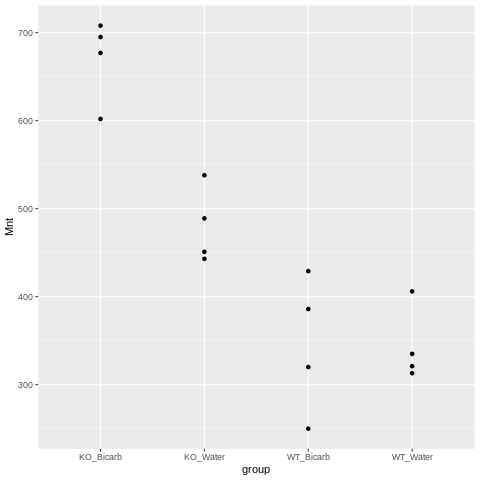

In [90]:
%%R

ggplot(cts,aes(x=group,y=Mnt))+
  geom_point()

Давайте реализуем log-link negative binomial GLM для каунтов гена Mnt:

In [91]:
%%R

model <- glm.nb(Mnt ~ KO*treat,data=cts,link=log)

In [92]:
%%R

summary(model)


Call:
glm.nb(formula = Mnt ~ KO * treat, data = cts, link = log, init.theta = 82.59683604)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.49427  -0.64224  -0.06323   0.58029   1.82663  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      6.50802    0.05831 111.618  < 2e-16 ***
KOWT            -0.66086    0.08455  -7.816 5.44e-15 ***
treatWater      -0.33372    0.08335  -4.004 6.23e-05 ***
KOWT:treatWater  0.32647    0.12021   2.716  0.00661 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(82.5968) family taken to be 1)

    Null deviance: 104.646  on 15  degrees of freedom
Residual deviance:  16.501  on 12  degrees of freedom
AIC: 182.88

Number of Fisher Scoring iterations: 1


              Theta:  82.6 
          Std. Err.:  35.8 

 2 x log-likelihood:  -172.884 


Эти P-value получены с помощью Wald test.

Теперь давайте проверим, как влияет нормализация на различия между образцами.

Для этого для начала постройте такой же график, как выше, но теперь для датафрейма `tpm`

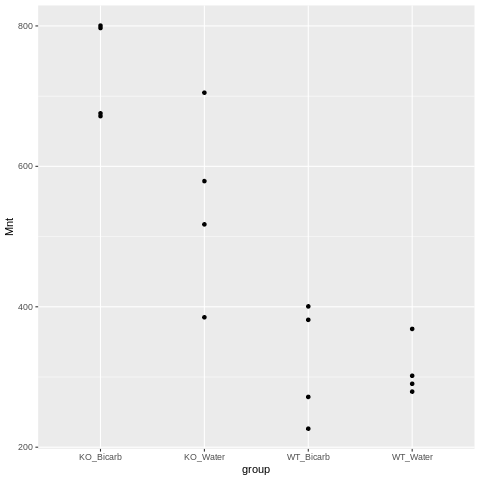

In [93]:
%%R

ggplot(tpm,aes(x=group,y=Mnt))+
  geom_point()

Что поменялось в наших данных при нормализации? Стала ли какая-нибудь из зависимостей менее выраженной?

Давайте переделаем модель, добавив к ней offset из датафрейма `normMat`:

In [94]:
%%R

model <- glm.nb(Mnt ~ KO*treat+offset(normMat$Mnt),data=cts,link=log)
summary(model)


Call:
glm.nb(formula = Mnt ~ KO * treat + offset(normMat$Mnt), data = cts, 
    link = log, init.theta = 49.78722134)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.45739  -0.49555  -0.03349   0.66635   1.69625  

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     -10.00707    0.07345 -136.238  < 2e-16 ***
KOWT             -0.65754    0.10558   -6.228 4.72e-10 ***
treatWater       -0.08209    0.10457   -0.785    0.432    
KOWT:treatWater   0.07689    0.14979    0.513    0.608    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(49.7872) family taken to be 1)

    Null deviance: 84.480  on 15  degrees of freedom
Residual deviance: 15.999  on 12  degrees of freedom
AIC: 189.43

Number of Fisher Scoring iterations: 1


              Theta:  49.8 
          Std. Err.:  19.5 

 2 x log-likelihood:  -179.433 


Учтем еще один нюанс: Wald test делается отдельно для каждого из факторов и их взаимодействия, что делает P-value заниженными ввиду множественного тестирования. Чтобы этого избежать, при наличии несколько факторов в эксперименте можно делать не Wald test, a likelihood ratio test (LRT), который тестирует всю модель сразу, итеративно сравнивая сначала модель с одним фактором с константной моделью, а затем добавляя другие факторы и их взаимодействие

In [95]:
%%R

anova(model,test="Chisq")

Analysis of Deviance Table

Model: Negative Binomial(49.7872), link: log

Response: Mnt

Terms added sequentially (first to last)


         Df Deviance Resid. Df Resid. Dev Pr(>Chi)    
NULL                        15     84.480             
KO        1   67.864        14     16.617   <2e-16 ***
treat     1    0.354        13     16.263   0.5518    
KO:treat  1    0.263        12     15.999   0.6079    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### Задание

Напишите цикл/функцию `apply`/... для тестирования всех генов с помощью GLM с offset. Она должна выдавать датафрейм, строчки которого соответствуют генам, а столбцы - LRT P-value для нокаута, treatment'а и их взаимодействия.

In [ ]:
%%R

#your code

Теперь с помощью `p.adjust(...,method="BH")` скорректируйте полученные P-value и выведите 10 генов с наиболее значимой дифф. экспрессией:

In [ ]:
%%R

#your code

## Анализ экспрессии с помощью edgeR, несколько независимых переменных

Давайте проделаем аналогичный анализ с помощью пакета edgeR.

Для начала заново получим матрицы `cts` и `normMat` в нетранспонированном виде:

In [80]:
%%R
cts <- txi$counts
normMat <- txi$length

# Obtaining per-observation scaling factors for length, adjusted to avoid
# changing the magnitude of the counts.
normMat <- normMat/exp(rowMeans(log(normMat)))
normCts <- cts/normMat

# Computing effective library sizes from scaled counts, to account for
# composition biases between samples.
eff.lib <- calcNormFactors(normCts) * colSums(normCts)

# Combining effective library sizes with the length factors, and calculating
# offsets for a log-link GLM.
normMat <- sweep(normMat, 2, eff.lib, "*")
normMat <- log(normMat)

genelen <- txi$length

Снова отфильтруем не белок-кодирующие гены

In [96]:
%%R

genetype <- mart$Gene.type[match(rownames(cts),mart$Gene.stable.ID)]
typefilter <- genetype == "protein_coding"
typefilter[is.na(typefilter)] <- FALSE
cts <- cts[typefilter,]
normMat <- normMat[typefilter,]
genelen <- genelen[typefilter,]

Создадим объект класса `DGEList`, с которым будут работать функции edgeR, а также содадим переменную `design`, в которую в подходящем для edgeR виде запишем информацию о дизайне эксперимента:

In [82]:
%%R

y <- DGEList(cts)
y <- scaleOffset(y, normMat)

knock <- c(rep("wt",8),rep("ko",8))
treat <- c(rep("water",4),rep("bicarb",4),rep("water",4),rep("bicarb",4))
group <- factor(str_c(knock,treat,sep="_"))
design <- model.matrix(~0+group)
colnames(design) <- levels(group)

In [83]:
%%R

design

   ko_bicarb ko_water wt_bicarb wt_water
1          0        0         0        1
2          0        0         0        1
3          0        0         0        1
4          0        0         0        1
5          0        0         1        0
6          0        0         1        0
7          0        0         1        0
8          0        0         1        0
9          0        1         0        0
10         0        1         0        0
11         0        1         0        0
12         0        1         0        0
13         1        0         0        0
14         1        0         0        0
15         1        0         0        0
16         1        0         0        0
attr(,"assign")
[1] 1 1 1 1
attr(,"contrasts")
attr(,"contrasts")$group
[1] "contr.treatment"



Добавим в наш `DGEList` названия генов и их NCBI ID

In [97]:
%%R

require(org.Mm.eg.db)
Symbol <- mapIds(org.Mm.eg.db, keys=rownames(y), keytype="ENSEMBL", column="SYMBOL")
Entrez <- mapIds(org.Mm.eg.db, keys=rownames(y), keytype="ENSEMBL", column="ENTREZID")
y$genes <- data.frame(Symbol=Symbol, Entrez=Entrez)
y$genes["length"] <- rowMeans(genelen)

Отфильтруем низко экспрессируемые гены и оценим дисперсии, чтобы применять к нашим данным quasi-likelihood F-test, реализованный в edgeR

In [98]:
%%R

keep <- filterByExpr(y,design=design,min.count=10,min.total.count=100,min.prop=0.25)
y <- y[keep, , keep.lib.sizes=FALSE]

y <- estimateDisp(y, design, robust=TRUE)

#последняя строчка эквивалентна двум следующим:
#y <- estimateCommonDisp(y)
#y <- estimateTagwiseDisp(y)

Зафитим GLM и проведем QLF-тест для всех попарных сравнений

In [99]:
%%R

fit <- glmQLFit(y, design, robust=TRUE)

my.contrasts <- makeContrasts(
  KO.BicarbvsWater = ko_bicarb-ko_water,
  WT.BicarbvsWater = wt_bicarb-wt_water,
  Bicarb.KOvsWT = ko_bicarb-wt_bicarb,
  Water.KOvsWT = ko_water-wt_water,
  KOWT.treat = (ko_bicarb-ko_water)-(wt_bicarb-wt_water),
  levels=design)

qlf_WaterKOWT <- glmQLFTest(fit, contrast=my.contrasts[,"Water.KOvsWT"])
qlf_BicarbKOWT <- glmQLFTest(fit, contrast=my.contrasts[,"Bicarb.KOvsWT"])
qlf_KOtreat <- glmQLFTest(fit, contrast=my.contrasts[,"KO.BicarbvsWater"])
qlf_WTtreat <- glmQLFTest(fit, contrast=my.contrasts[,"WT.BicarbvsWater"])
qlf_KOWTtreat <- glmQLFTest(fit, contrast=my.contrasts[,"KOWT.treat"])

Мы могли бы также добавить взаимодействие между этими факторами в нашу матрицу design, и тогда задать отдельные contrasts для этих взаимодействий

Посмотрим на число DE-генов

In [100]:
%%R

print(summary(decideTests(qlf_WaterKOWT)))
print(summary(decideTests(qlf_BicarbKOWT)))
print(summary(decideTests(qlf_KOtreat)))
print(summary(decideTests(qlf_WTtreat)))

       1*ko_water -1*wt_water
Down                     1547
NotSig                  12043
Up                       1384
       1*ko_bicarb -1*wt_bicarb
Down                       1244
NotSig                    12427
Up                         1303
       1*ko_bicarb -1*ko_water
Down                         2
NotSig                   14971
Up                           1
       1*wt_bicarb -1*wt_water
Down                        12
NotSig                   14958
Up                           4


Запишем в отдельные переменные датафреймы с p-value, FDR и logFC всех генов для всех сравнений

In [101]:
%%R

qlftable_WaterKOWT <- topTags(qlf_WaterKOWT,n=nrow(y))$table
qlftable_BicarbKOWT <- topTags(qlf_BicarbKOWT,n=nrow(y))$table
qlftable_KOtreat <- topTags(qlf_KOtreat,n=nrow(y))$table
qlftable_WTtreat <- topTags(qlf_WTtreat,n=nrow(y))$table

In [ ]:
%%R

head(qlftable_WaterKOWT)

                   Symbol Entrez     length    logFC    logCPM        F
ENSMUSG00000059412  Fxyd2  11936  499.05819 2.038222  8.886038 687.2928
ENSMUSG00000045968 Teddm2 240817 2163.54411 3.896632  2.864537 328.3608
ENSMUSG00000064368    ND6  17722  251.00000 1.494899 13.378434 316.1121
ENSMUSG00000045128 Rpl18a  76808 1115.88125 3.704402  6.109092 325.6221
ENSMUSG00000064356   ATP8  17706   11.60825 1.204768 13.577948 280.6929
ENSMUSG00000026575   Nme7 171567  644.21467 1.708816  4.537958 259.1236
                         PValue          FDR
ENSMUSG00000059412 3.734162e-14 5.014979e-10
ENSMUSG00000045968 9.065399e-12 4.239258e-08
ENSMUSG00000064368 1.198212e-11 4.239258e-08
ENSMUSG00000045128 1.262623e-11 4.239258e-08
ENSMUSG00000064356 2.856974e-11 7.673832e-08
ENSMUSG00000026575 5.112129e-11 9.676310e-08


### Задание

Постройте гистограммы p-value по полученным датафреймам. О чем они свидетельствуют?

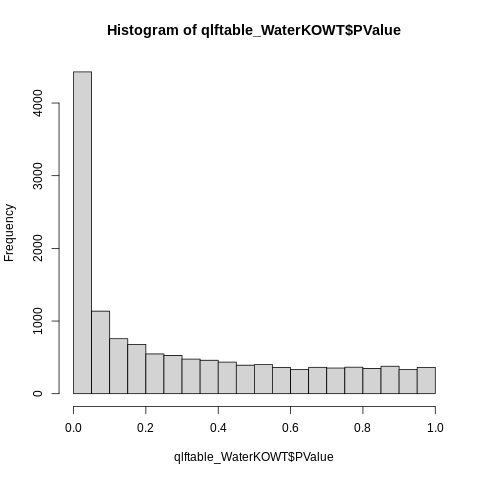

In [ ]:
%%R

hist(qlftable_WaterKOWT$PValue)

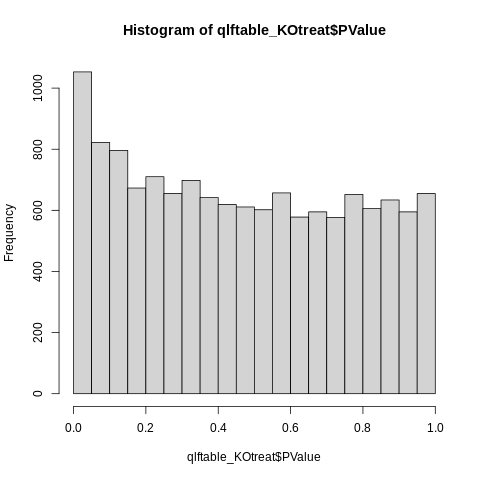

In [ ]:
%%R

hist(qlftable_KOtreat$PValue)

Отрисуйте Volcano plots по этим четырем датафреймам.

Какие факторы влияют на экспрессию?

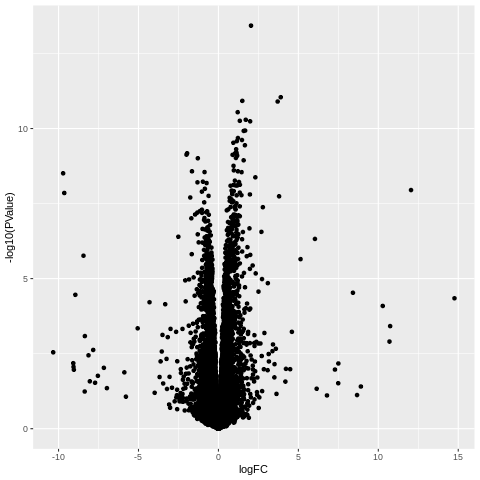

In [ ]:
%%R

ggplot(qlftable_WaterKOWT,aes(x=logFC,y=-log10(PValue)))+
  geom_point()

## Домашнее задание

Проведите аналогичный анализ с помощью DESeq2 и сравните его результаты с результатами edgeR и реализованной нами GLM (можете построить scatter plot для p-value, полученных разными методами).

В чем основные различия используемых моделей и тестов?

Для этого нужно будет:

1.   Импортировать еще раз из аутпута salmon наши каунты, но теперь выгрузить в DESeq2, а не в edgeR (https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html#DESeq2)
2.   Реализовать стандартный пайплайн DESeq2, сравнивая с тем, как это делается в edgeR (https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)



**Решение домашнего задания**

Проведем стандартный анализ с помощью DESeq2.

In [ ]:
%%R

install.packages("DESeq2")
library(DESeq2)

In [ ]:
%%R
txdb <- EnsDb.Mmusculus.v79
tx2gene <- transcripts(txdb,return.type="DataFrame")
tx2gene <- tx2gene[c("tx_id","gene_id")]
files <- str_c("data/samples/",samples)
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T)
tpm <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T, countsFromAbundance = "lengthScaledTPM")$counts

In [ ]:
%%R
sampleTable <- data.frame(condition = factor(rep(c("wt_water","wt_bicarb","ko_water","ko_bicarb"),each=4)))
dds <- DESeqDataSetFromTximport(txi, sampleTable, ~condition)
dds <- DESeq(dds)

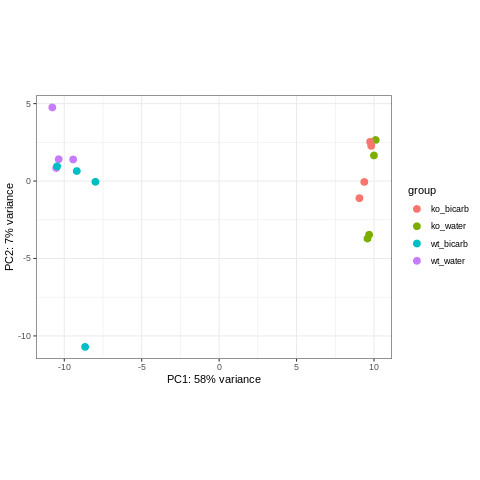

In [55]:
%%R
vsdata <- vst(dds, blind=FALSE)
plotPCA(vsdata, intgroup="condition")+ theme_bw() 

Видим, что на PCA достаточно наши образцы достаточно хорошо разделяются по генотипу. Посмотрим на изменение экспрессии генов между различными группами. Сначала глянем на краткое описание результатов работы DESeq2, чтобы понять, сколько у нас генов изменило свою экспрессию. 

In [59]:
%%R
summary(res)


out of 27530 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 323, 1.2%
LFC < 0 (down)     : 139, 0.5%
outliers [1]       : 101, 0.37%
low counts [2]     : 15582, 57%
(mean count < 36)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Видим, что больше половины генов обладали слишком низким количество каунтов (57%). Ну ладно. Посмотрим на изменение экспрессии генов в мышах дикого типа с бикарбонатной диетой и в нокаутных мышах с такой диетой.

In [106]:
%%R
resultsNames(dds)

[1] "Intercept"                        "condition_ko_water_vs_ko_bicarb" 
[3] "condition_wt_bicarb_vs_ko_bicarb" "condition_wt_water_vs_ko_bicarb" 


In [65]:
%%R
res <- na.omit(results(dds, name="condition_wt_bicarb_vs_ko_bicarb"))
data_for_volcano_plot <- data.frame(log2FC = res$log2FoldChange, padj = res$padj)

[[1]]

[[2]]



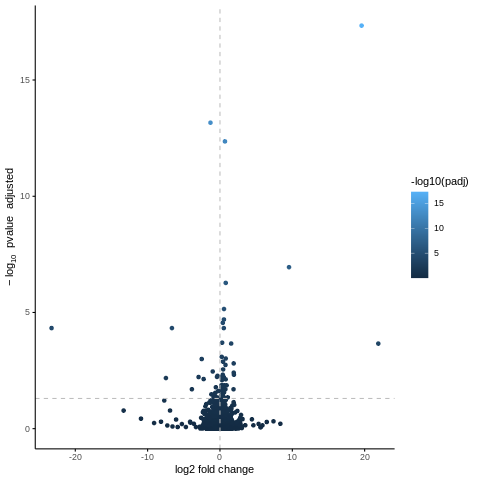

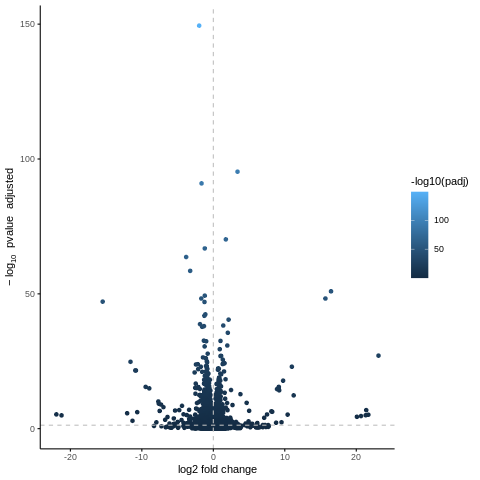

In [120]:
%%R
volcano <- function(condition){
  res <- na.omit(results(dds, name=condition))
  data_for_volcano_plot <- data.frame(log2FC = res$log2FoldChange, padj = res$padj)
  data_for_volcano_plot %>% 
  ggplot(aes(x=log2FC,y=-log10(padj)))+
  geom_point(aes(color = -log10(padj)))+
  theme_bw()+
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    axis.line = element_line(color="black",
                             size=0.5),
    axis.ticks = element_line(color = "black",
                              size=0.5)
  )+
  geom_vline(xintercept=0,linetype="dashed",color="grey")+
  geom_hline(yintercept = -log10(0.05),linetype="dashed",color="grey")+
  labs(
    y = expression(-log[10]~pvalue~adjusted),
    x = "log2 fold change"
  )  
}

conditions <- list("condition_ko_water_vs_ko_bicarb","condition_wt_bicarb_vs_ko_bicarb")
lapply(conditions,volcano)

Сравним p-value генов, полученных в результате работы нашей GLM-модели и DESeq2 на основании анализа дифф.экспрессии в групах "нокаутные мыши на бикарбонатной диете" и "мыши дикого типа на бикарбонатной диете".

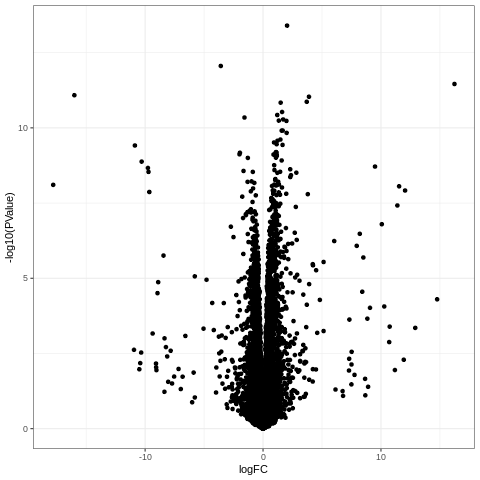

In [119]:
%%R
ggplot(qlftable_WaterKOWT,aes(x=logFC,y=-log10(PValue)))+
  geom_point()+
  theme_bw()

Видим, что в DESeq2 есть точки с огромным logFoldChange (>20), такого нет в GLM-модели, и высоких значений p-value (в DESeq2 есть точка на значениях 150) тоже не наблюдается. Возможно, это те самые гены, которые прям очень дифференциально экспрессируются, а может быть, это DESeq2 начудил, и это какие-то аутлайеры, которые весьма странно себя ведут (может быть, покрытие гена низкое вообще, и поэтому такая сильная разница). Тут я сказать, честно говоря, не могу.

**Чем edgeR отличается от DESeq2**

Насколько я понял, там есть различия в процессе нормализации данных. DESeq2 нормализует на среднее геометрическое, а edgeR во время нормализации основывается на логарифмах взвешенных средних. Также я видел заявления, что у edgeR более строгий контроль за ошибками (more rigorous error rate control).

Смотрел информацию на BioStars (https://www.biostars.org/p/284775/)
